17:30:21 - cmdstanpy - INFO - Chain [1] start processing
17:32:39 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
1801 2024-12-06  268.606195 -259.041705  775.933514
1802 2024-12-07  268.197301 -257.333647  764.321418
1803 2024-12-08  266.841644 -245.242358  745.998431
1804 2024-12-09  267.416718 -254.124536  764.035196
1805 2024-12-10  267.297160 -272.401684  776.631775


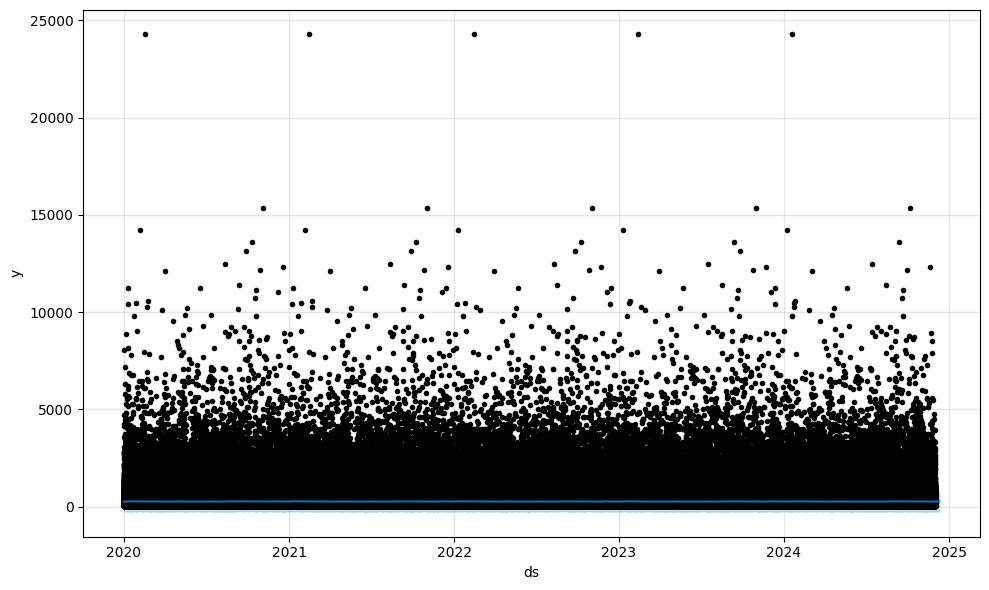

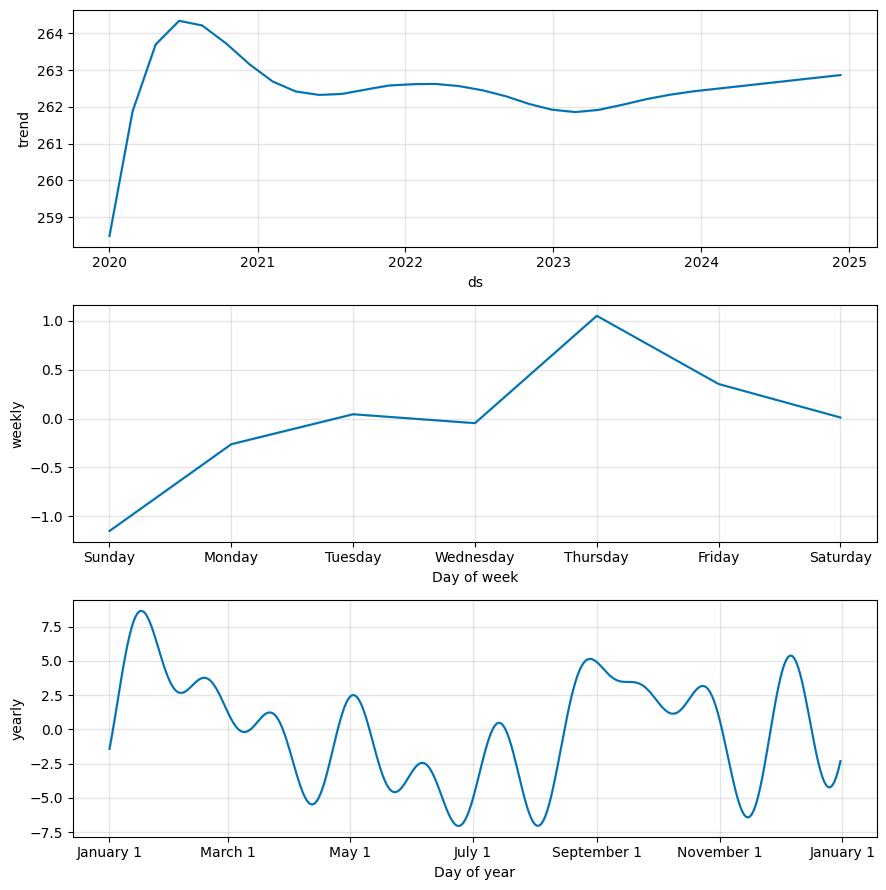

In [7]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta

# Load data
data = pd.read_csv('../data/train_replicated_with_dates.csv')

# Convert 'date' to datetime and rename it to 'ds' for Prophet
data['ds'] = pd.to_datetime(data['date'], errors='coerce')
data['y'] = data['num_orders']

# Remove any rows where 'ds' couldn't be converted (which would result in NaT)
data = data.dropna(subset=['ds'])

# Check for out of bounds dates
out_of_bounds = data['ds'] > pd.Timestamp('2262-04-11')
if out_of_bounds.any():
    print("Number of out of bounds dates:", out_of_bounds.sum())
    print("Sample of out of bounds dates:", data['ds'][out_of_bounds].head())
    # If you have out of bounds dates, you might want to filter them out or handle them differently
    data = data[~out_of_bounds]

# Now you can proceed with Prophet
m = Prophet()

# Fit the model
m.fit(data)

# Make future dataframe for predictions. Here, we'll predict for the next 10 days
future = m.make_future_dataframe(periods=10)

# Predict
forecast = m.predict(future)

# View the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [12]:
import holidays
from prophet import Prophet
import pandas as pd

# Example for US holidays
us_holidays = holidays.US(years=[2020, 2021, 2022])  # Adjust years as needed
holiday_df = pd.DataFrame.from_dict(us_holidays, orient='index').reset_index()
holiday_df.columns = ['ds', 'holiday']
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1  # Adjust as needed

m = Prophet(holidays=holiday_df)
m.fit(data)

17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Make future dataframe for predictions
future = m.make_future_dataframe(periods=10)  # Predict for next 10 days

# Predict
forecast = m.predict(future)

# View the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
1801 2024-12-06  268.032340 -259.952738  784.629674
1802 2024-12-07  267.793862 -236.268188  785.731981
1803 2024-12-08  266.511937 -211.898229  776.142149
1804 2024-12-09  267.427929 -207.065288  794.958152
1805 2024-12-10  267.389585 -225.210734  773.038880


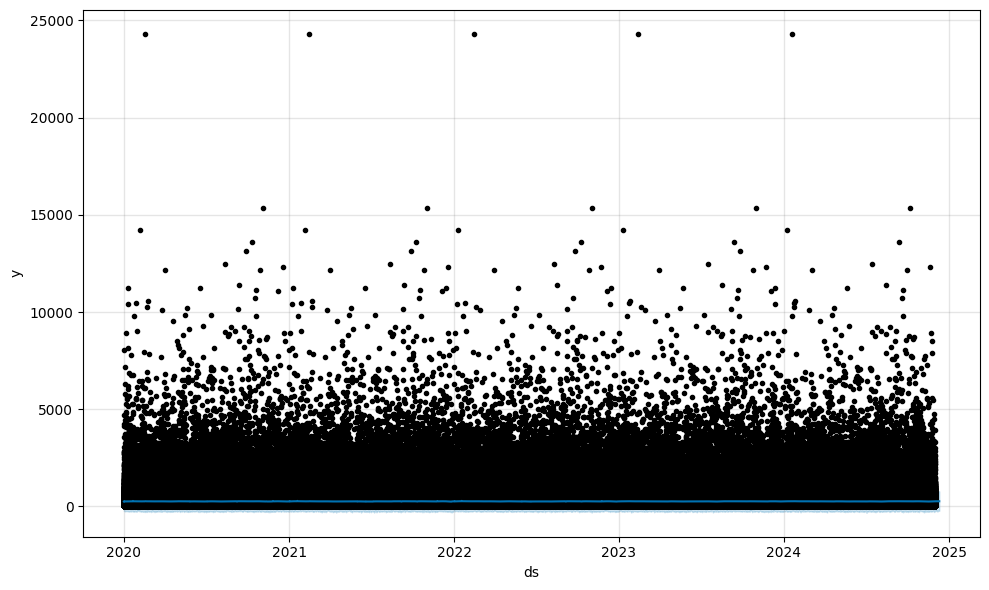

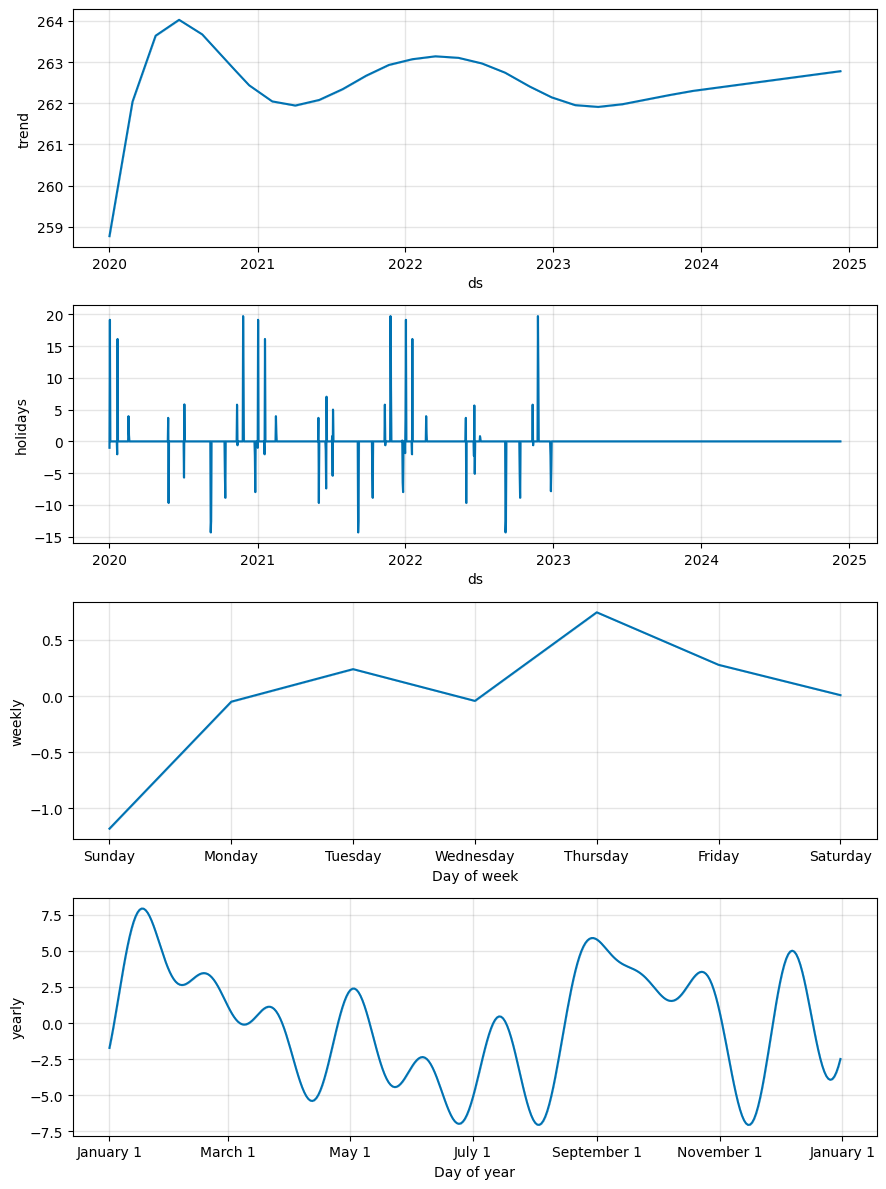

In [14]:
# Plot the forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

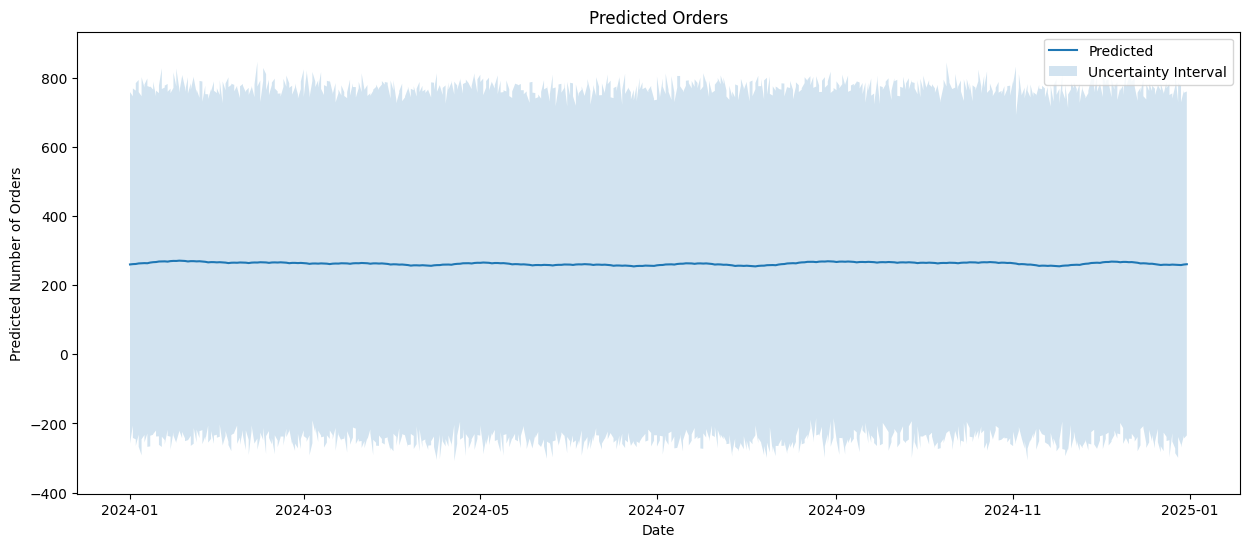

In [19]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your training data, and you've already fitted the model 'm'

# Load your test data
test_data = pd.read_csv('../data/test_replicated_with_dates.csv')  # Adjust the path accordingly

# Prepare test data for Prophet
test_data['ds'] = pd.to_datetime(test_data['date'])

# Use the fitted model to predict on test data
test_forecast = m.predict(test_data[['ds']])

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Predicted')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], alpha=0.2, label='Uncertainty Interval')
plt.legend()
plt.title('Predicted Orders')
plt.xlabel('Date')
plt.ylabel('Predicted Number of Orders')
plt.show()

In [21]:
# Save predictions for later comparison
test_forecast[['ds', 'yhat']].to_csv('predictions_for_test_period.csv', index=False)

In [22]:
m = Prophet(uncertainty_samples=100)
m.fit(data[['ds', 'y']])  # Re-fit with new settings

18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Use only the last part of your data for evaluation
subset_data = data.iloc[-10000:]  # last 10,000 rows, for example
historical_forecast = m.predict(subset_data[['ds']])
mse = mean_squared_error(subset_data['y'], historical_forecast['yhat'])
rmse = np.sqrt(mse)
print("RMSE on Subset of Training Data:", rmse)

RMSE on Subset of Training Data: 366.1590430796027


In [24]:
m = Prophet(uncertainty_samples=0)
m.fit(data[['ds', 'y']])
historical_forecast = m.predict(data[['ds']])
mse = mean_squared_error(data['y'], historical_forecast['yhat'])
rmse = np.sqrt(mse)
print("RMSE on Training Data (without uncertainty):", rmse)

18:16:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE on Training Data (without uncertainty): 398.3391029171045


In [25]:
m = Prophet(uncertainty_samples=1000, stan_backend='cmdstanpy', backend_kwargs={'data_type': np.float32})
m.fit(data[['ds', 'y']])
historical_forecast = m.predict(data[['ds']])

TypeError: Prophet.__init__() got an unexpected keyword argument 'backend_kwargs'

In [26]:
chunk_size = 10000  # Adjust based on your memory constraints
rmse_list = []

for i in range(0, len(data), chunk_size):
    chunk = data.iloc[i:i+chunk_size]
    chunk_forecast = m.predict(chunk[['ds']])
    rmse_list.append(np.sqrt(mean_squared_error(chunk['y'], chunk_forecast['yhat'])))

average_rmse = np.mean(rmse_list)
print("Average RMSE on Training Data in Chunks:", average_rmse)

Average RMSE on Training Data in Chunks: 385.6609686795761


18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
1801 2024-12-06  268.942719 -253.435047  758.259597
1802 2024-12-07  268.549430 -227.373743  788.905649
1803 2024-12-08  267.132377 -271.185685  770.454129
1804 2024-12-09  267.675923 -233.930261  772.762533
1805 2024-12-10  267.786506 -261.270587  784.036205


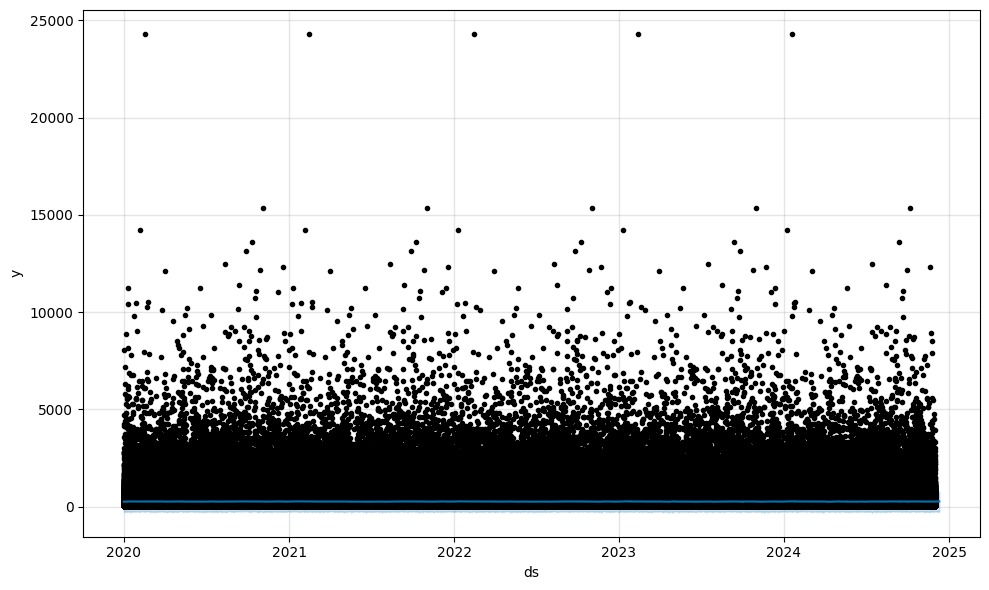

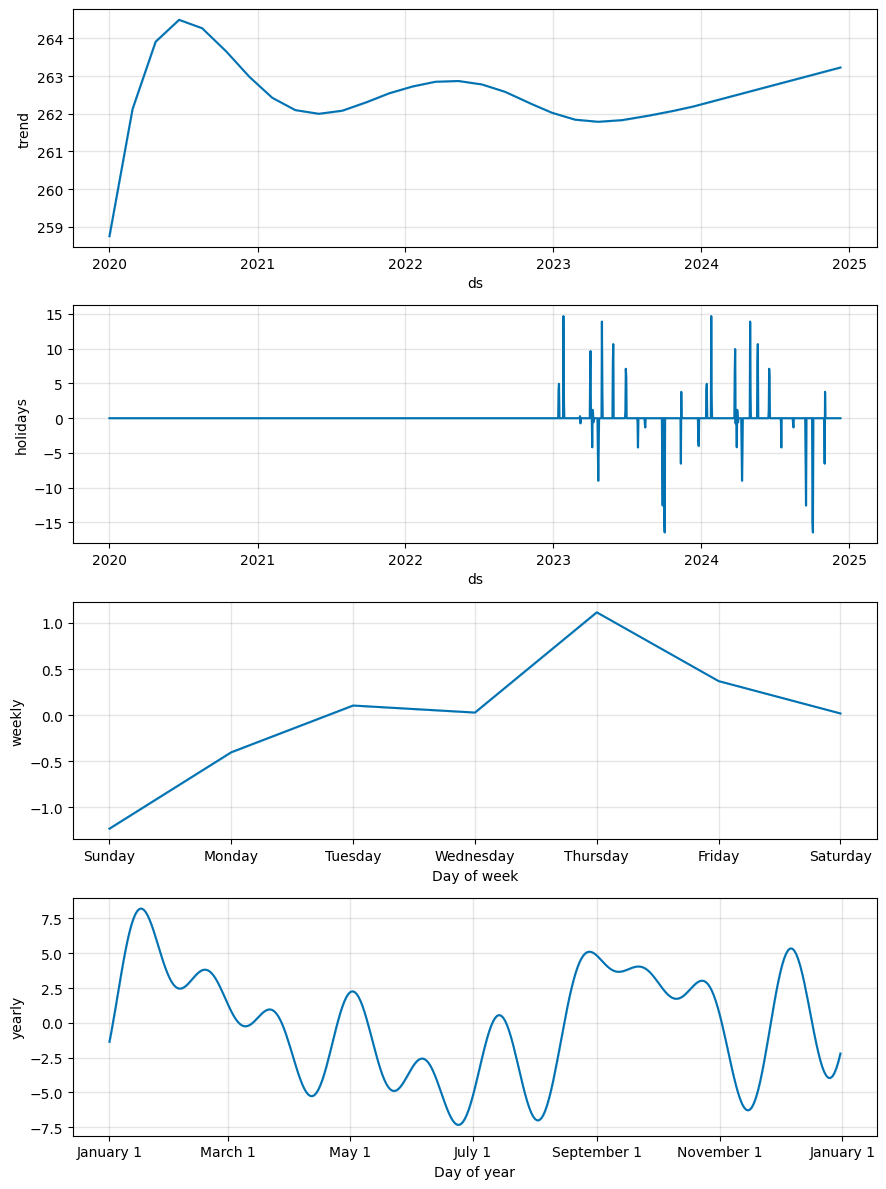

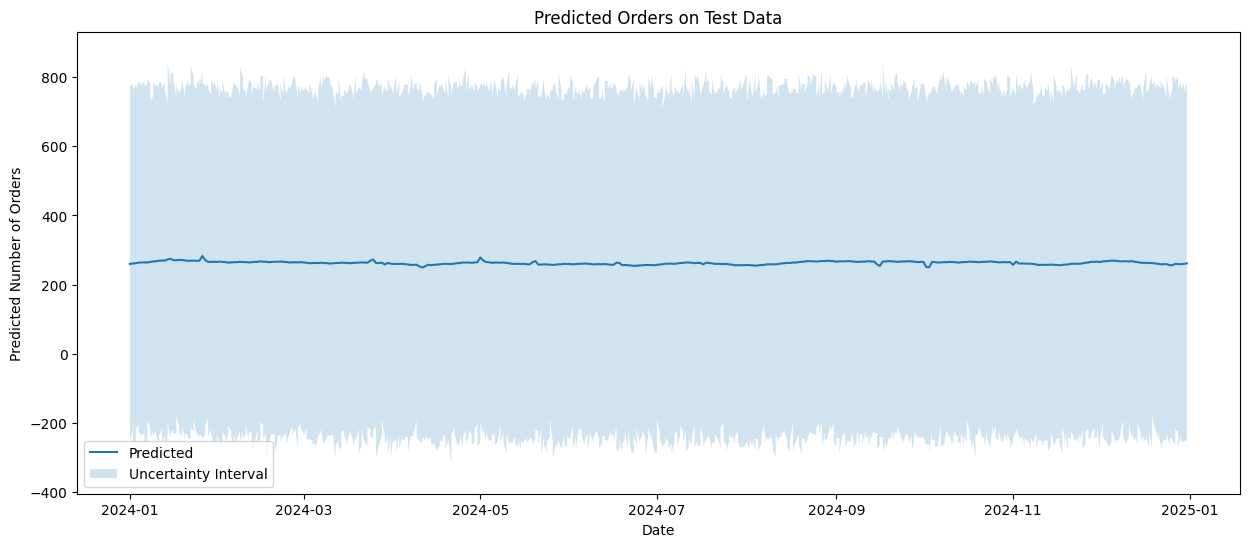

RMSE on Subset of Training Data: 366.16120534084945


18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE on Training Data (without uncertainty): 398.3391029171045
Average RMSE on Training Data in Chunks: 385.6609686795761


In [29]:
import pickle
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from holidays import IN

# Load data
data = pd.read_csv('../data/train_replicated_with_dates.csv')

# Convert 'date' to datetime and rename it to 'ds' for Prophet
data['ds'] = pd.to_datetime(data['date'], errors='coerce')
data['y'] = data['num_orders']

# Remove any rows where 'ds' couldn't be converted (which would result in NaT)
data = data.dropna(subset=['ds'])

# Check for out of bounds dates
out_of_bounds = data['ds'] > pd.Timestamp('2262-04-11')
if out_of_bounds.any():
    print("Number of out of bounds dates:", out_of_bounds.sum())
    print("Sample of out of bounds dates:", data['ds'][out_of_bounds].head())
    # If you have out of bounds dates, you might want to filter them out or handle them differently
    data = data[~out_of_bounds]

# Define holidays (replace with relevant holidays for your region)
india_holidays = holidays.IN(years=range(2023, 2025))  # Adjust years as needed
holiday_df = pd.DataFrame.from_dict(india_holidays, orient='index').reset_index()
holiday_df.columns = ['ds', 'holiday']
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1  # Adjust as needed

# Create Prophet model with holidays
m = Prophet(holidays=holiday_df)

# Fit the model
m.fit(data)

# Save the trained model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)

# Make future dataframe for predictions (e.g., next 10 days)
future = m.make_future_dataframe(periods=10)

# Predict
forecast = m.predict(future)

# View the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()  # Display plots

# Load test data (assuming 'test_replicated_with_dates.csv' exists)
test_data = pd.read_csv('../data/test_replicated_with_dates.csv')
test_data['ds'] = pd.to_datetime(test_data['date'])

# Predict on test data
test_forecast = m.predict(test_data[['ds']])

# Plot test data predictions
plt.figure(figsize=(15, 6))
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Predicted')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], alpha=0.2,
                 label='Uncertainty Interval')
plt.legend()
plt.title('Predicted Orders on Test Data')
plt.xlabel('Date')
plt.ylabel('Predicted Number of Orders')
plt.show()

# Save predictions for later comparison (optional)
test_forecast[['ds', 'yhat']].to_csv('predictions_for_test_period.csv', index=False)

# Evaluate model performance on a subset of training data (e.g., last 10000 rows)
subset_data = data.iloc[-10000:]
historical_forecast = m.predict(subset_data[['ds']])
mse = mean_squared_error(subset_data['y'], historical_forecast['yhat'])
rmse = np.sqrt(mse)
print("RMSE on Subset of Training Data:", rmse)

# Evaluate model performance on entire training data (without uncertainty sampling)
m = Prophet(uncertainty_samples=0)
m.fit(data[['ds', 'y']])
historical_forecast = m.predict(data[['ds']])
mse = mean_squared_error(data['y'], historical_forecast['yhat'])
rmse = np.sqrt(mse)
print("RMSE on Training Data (without uncertainty):", rmse)

# Evaluate model performance on training data in chunks
chunk_size = 10000  # Adjust based on your memory constraints
rmse_list = []

for i in range(0, len(data), chunk_size):
    chunk = data.iloc[i:i+chunk_size]
    chunk_forecast = m.predict(chunk[['ds']])
    rmse_list.append(np.sqrt(mean_squared_error(chunk['y'], chunk_forecast['yhat'])))

average_rmse = np.mean(rmse_list)
print("Average RMSE on Training Data in Chunks:", average_rmse)